# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

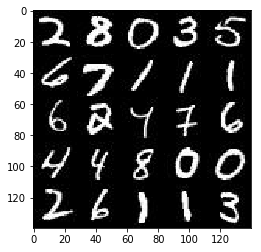

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

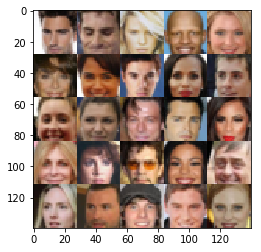

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2, n_filters=64):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):

        # convolutional layer, output = 14x14x64 
        x1 = tf.layers.conv2d(images, n_filters, 5, strides=2, padding='same')
        #a1 = tf.nn.leaky_relu(x1, alpha)
        a1 = tf.maximum(alpha*x1, x1)

        # convolutional layer, output = 7x7x128 
        x2 = tf.layers.conv2d(a1, 2*n_filters, 5, strides=2, padding='same')
        n2 = tf.layers.batch_normalization(x2, training=True)
        #a2 = tf.nn.leaky_relu(n2,alpha)
        a2 = tf.maximum(alpha*n2,n2)
    
        # convolutional layer, output = 2x2x256
        x3 = tf.layers.conv2d(a2, 4*n_filters, 5, strides=2, padding='valid')
        n3 = tf.layers.batch_normalization(x3, training=True)
        #a3 = tf.nn.leaky_relu(n3, alpha)
        a3 = tf.maximum(alpha*n3,n3)
    
        # flatten, output = 1024  
        x4 = tf.reshape(a3, (-1, 2*2*(4*n_filters)))
        logits = tf.layers.dense(x4, 1)
    
        output = tf.sigmoid(logits)
    
        return output, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, n_filters=64):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    with tf.variable_scope('generator',reuse=reuse):

        # First fully connected layer
        x4 = tf.layers.dense(z, 2*2*(4*n_filters), activation=None)

        # Start the convolutional stack, output 2x2x256
        x3 = tf.reshape(x4, (-1, 2, 2, 4*n_filters))
        n3 = tf.layers.batch_normalization(x3, training=is_train)
        #a3 = tf.nn.leaky_relu(n3, alpha)
        a3 = tf.maximum(alpha*n3,n3)
        
        # Convolutional transpose layer, output = 7x7x128
        x2 = tf.layers.conv2d_transpose(a3, 2*n_filters, 5, strides=2, padding='valid', activation=None)
        n2 = tf.layers.batch_normalization(x2, training=is_train)
        #a2 = tf.nn.leaky_relu(n2, alpha)
        a2 = tf.maximum(alpha*n2,n2)
        
        # Convolutional transpose layer, output = 14x14x64      
        x1 = tf.layers.conv2d_transpose(a2, n_filters, 5, strides=2, padding='same', activation=None)
        n1 = tf.layers.batch_normalization(x1, training=is_train)
        #a1 = tf.nn.leaky_relu(n1, alpha)
        a1 = tf.maximum(alpha*n1,n1)
        
        # Convolutional transpose layer, output = 28x28x3
        logits = tf.layers.conv2d_transpose(a1, out_channel_dim, 5, strides=2, padding='same', activation=None)

        
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    n_filters = 64
    smooth = 0.1

    g_model = generator(input_z, out_channel_dim, alpha=alpha, n_filters=n_filters)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha, n_filters=n_filters)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha, n_filters=n_filters)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, alpha=0.2):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model
    out_channel_dim = data_shape[3]
    n_images = 25
    print_every = 10
    plot_every = 100

    input_real, input_z, model_lr = model_inputs(data_shape[1], data_shape[2], out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim, alpha=alpha)
    d_opt, g_opt = model_opt(d_loss, g_loss, model_lr, beta1)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            step = 0
            n_steps = np.ceil(data_shape[0]/batch_size).astype(np.int)
            for batch_images in get_batches(batch_size):
                
                # Sample random noise for G  
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Scale the batch_images by 2 since they were incorrectly normalized for this project.
                batch_images = 2*batch_images
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, model_lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, model_lr: learning_rate})
            
                # print out the discriminator and generator training losses
                if step == 0 or (step + 1) % print_every == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z, model_lr: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, model_lr: learning_rate})

                    losses.append((train_loss_d, train_loss_g))
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                            "Step {}/{}...".format(step+1, n_steps),
                            "Discriminator Loss: {:.4f}...".format(train_loss_d),
                            "Generator Loss: {:.4f}".format(train_loss_g))

                if step == 0 or (step+1) % plot_every == 0:
                    show_generator_output(sess, n_images, input_z, out_channel_dim, data_image_mode)

                step += 1
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step 1/600... Discriminator Loss: 8.7066... Generator Loss: 0.0009


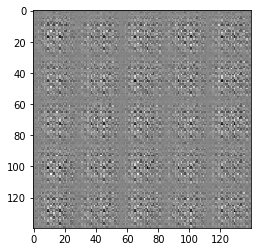

Epoch 1/2... Step 10/600... Discriminator Loss: 0.9643... Generator Loss: 1.2312
Epoch 1/2... Step 20/600... Discriminator Loss: 0.5496... Generator Loss: 3.1283
Epoch 1/2... Step 30/600... Discriminator Loss: 1.1768... Generator Loss: 0.6864
Epoch 1/2... Step 40/600... Discriminator Loss: 0.7121... Generator Loss: 2.3205
Epoch 1/2... Step 50/600... Discriminator Loss: 1.6232... Generator Loss: 0.4510
Epoch 1/2... Step 60/600... Discriminator Loss: 0.4841... Generator Loss: 2.9211
Epoch 1/2... Step 70/600... Discriminator Loss: 0.8497... Generator Loss: 1.0578
Epoch 1/2... Step 80/600... Discriminator Loss: 0.5318... Generator Loss: 2.7187
Epoch 1/2... Step 90/600... Discriminator Loss: 0.7411... Generator Loss: 1.7195
Epoch 1/2... Step 100/600... Discriminator Loss: 0.7619... Generator Loss: 1.3380


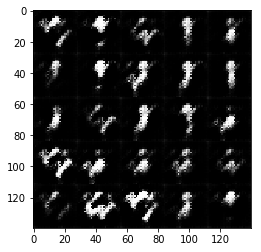

Epoch 1/2... Step 110/600... Discriminator Loss: 0.7762... Generator Loss: 1.5049
Epoch 1/2... Step 120/600... Discriminator Loss: 0.9153... Generator Loss: 1.8432
Epoch 1/2... Step 130/600... Discriminator Loss: 0.6693... Generator Loss: 1.6996
Epoch 1/2... Step 140/600... Discriminator Loss: 1.0128... Generator Loss: 2.9797
Epoch 1/2... Step 150/600... Discriminator Loss: 1.9802... Generator Loss: 5.3465
Epoch 1/2... Step 160/600... Discriminator Loss: 0.8301... Generator Loss: 2.2751
Epoch 1/2... Step 170/600... Discriminator Loss: 0.9378... Generator Loss: 2.1799
Epoch 1/2... Step 180/600... Discriminator Loss: 1.1772... Generator Loss: 3.0653
Epoch 1/2... Step 190/600... Discriminator Loss: 1.7315... Generator Loss: 3.0164
Epoch 1/2... Step 200/600... Discriminator Loss: 0.9645... Generator Loss: 1.1528


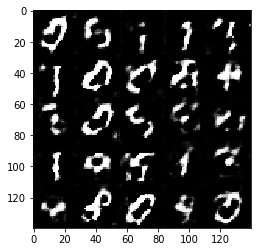

Epoch 1/2... Step 210/600... Discriminator Loss: 0.9956... Generator Loss: 2.2517
Epoch 1/2... Step 220/600... Discriminator Loss: 1.0307... Generator Loss: 0.8463
Epoch 1/2... Step 230/600... Discriminator Loss: 1.0410... Generator Loss: 0.9944
Epoch 1/2... Step 240/600... Discriminator Loss: 0.9543... Generator Loss: 1.4136
Epoch 1/2... Step 250/600... Discriminator Loss: 0.9621... Generator Loss: 1.3215
Epoch 1/2... Step 260/600... Discriminator Loss: 1.0912... Generator Loss: 1.1687
Epoch 1/2... Step 270/600... Discriminator Loss: 0.9427... Generator Loss: 1.4424
Epoch 1/2... Step 280/600... Discriminator Loss: 0.9985... Generator Loss: 1.4637
Epoch 1/2... Step 290/600... Discriminator Loss: 1.1706... Generator Loss: 2.1075
Epoch 1/2... Step 300/600... Discriminator Loss: 0.9895... Generator Loss: 1.0282


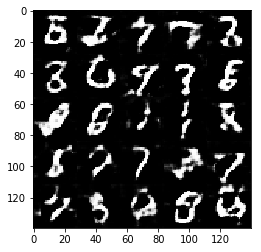

Epoch 1/2... Step 310/600... Discriminator Loss: 0.9739... Generator Loss: 1.5028
Epoch 1/2... Step 320/600... Discriminator Loss: 1.1890... Generator Loss: 1.8843
Epoch 1/2... Step 330/600... Discriminator Loss: 0.8991... Generator Loss: 1.9004
Epoch 1/2... Step 340/600... Discriminator Loss: 0.9807... Generator Loss: 1.1709
Epoch 1/2... Step 350/600... Discriminator Loss: 0.9715... Generator Loss: 2.0694
Epoch 1/2... Step 360/600... Discriminator Loss: 0.9504... Generator Loss: 1.2132
Epoch 1/2... Step 370/600... Discriminator Loss: 1.0169... Generator Loss: 1.6438
Epoch 1/2... Step 380/600... Discriminator Loss: 0.9144... Generator Loss: 1.3138
Epoch 1/2... Step 390/600... Discriminator Loss: 1.0020... Generator Loss: 1.3481
Epoch 1/2... Step 400/600... Discriminator Loss: 1.0289... Generator Loss: 1.0280


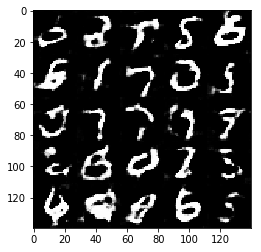

Epoch 1/2... Step 410/600... Discriminator Loss: 1.2735... Generator Loss: 2.4345
Epoch 1/2... Step 420/600... Discriminator Loss: 0.8868... Generator Loss: 1.1532
Epoch 1/2... Step 430/600... Discriminator Loss: 0.9792... Generator Loss: 0.9322
Epoch 1/2... Step 440/600... Discriminator Loss: 1.2643... Generator Loss: 0.6627
Epoch 1/2... Step 450/600... Discriminator Loss: 0.9864... Generator Loss: 1.2966
Epoch 1/2... Step 460/600... Discriminator Loss: 1.0078... Generator Loss: 1.9937
Epoch 1/2... Step 470/600... Discriminator Loss: 0.9827... Generator Loss: 1.0578
Epoch 1/2... Step 480/600... Discriminator Loss: 1.6630... Generator Loss: 0.3698
Epoch 1/2... Step 490/600... Discriminator Loss: 1.2192... Generator Loss: 0.7100
Epoch 1/2... Step 500/600... Discriminator Loss: 1.0431... Generator Loss: 1.0242


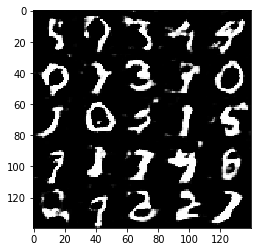

Epoch 1/2... Step 510/600... Discriminator Loss: 1.6232... Generator Loss: 0.4039
Epoch 1/2... Step 520/600... Discriminator Loss: 1.0832... Generator Loss: 0.8807
Epoch 1/2... Step 530/600... Discriminator Loss: 1.2612... Generator Loss: 0.7123
Epoch 1/2... Step 540/600... Discriminator Loss: 0.9489... Generator Loss: 1.2328
Epoch 1/2... Step 550/600... Discriminator Loss: 1.0937... Generator Loss: 1.4557
Epoch 1/2... Step 560/600... Discriminator Loss: 1.0860... Generator Loss: 1.3677
Epoch 1/2... Step 570/600... Discriminator Loss: 0.9821... Generator Loss: 1.1408
Epoch 1/2... Step 580/600... Discriminator Loss: 1.0279... Generator Loss: 1.2899
Epoch 1/2... Step 590/600... Discriminator Loss: 1.0181... Generator Loss: 1.4376
Epoch 1/2... Step 600/600... Discriminator Loss: 0.9747... Generator Loss: 1.1145


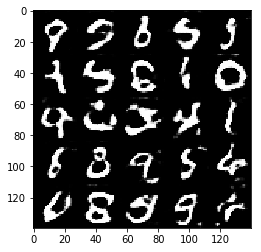

Epoch 2/2... Step 1/600... Discriminator Loss: 0.9734... Generator Loss: 1.2638


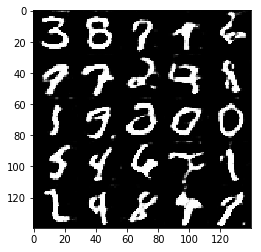

Epoch 2/2... Step 10/600... Discriminator Loss: 1.1582... Generator Loss: 0.8200
Epoch 2/2... Step 20/600... Discriminator Loss: 0.9788... Generator Loss: 1.1026
Epoch 2/2... Step 30/600... Discriminator Loss: 1.1758... Generator Loss: 0.7407
Epoch 2/2... Step 40/600... Discriminator Loss: 1.1451... Generator Loss: 0.7997
Epoch 2/2... Step 50/600... Discriminator Loss: 0.9589... Generator Loss: 1.1367
Epoch 2/2... Step 60/600... Discriminator Loss: 1.2071... Generator Loss: 0.6883
Epoch 2/2... Step 70/600... Discriminator Loss: 1.0722... Generator Loss: 1.4674
Epoch 2/2... Step 80/600... Discriminator Loss: 1.1932... Generator Loss: 0.7107
Epoch 2/2... Step 90/600... Discriminator Loss: 1.1132... Generator Loss: 1.3191
Epoch 2/2... Step 100/600... Discriminator Loss: 1.4986... Generator Loss: 0.4609


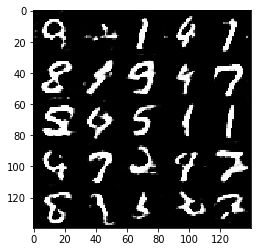

Epoch 2/2... Step 110/600... Discriminator Loss: 1.1271... Generator Loss: 0.9085
Epoch 2/2... Step 120/600... Discriminator Loss: 0.9875... Generator Loss: 1.0327
Epoch 2/2... Step 130/600... Discriminator Loss: 0.9705... Generator Loss: 1.3683
Epoch 2/2... Step 140/600... Discriminator Loss: 1.0885... Generator Loss: 1.1249
Epoch 2/2... Step 150/600... Discriminator Loss: 1.0472... Generator Loss: 1.3571
Epoch 2/2... Step 160/600... Discriminator Loss: 1.0146... Generator Loss: 1.1030
Epoch 2/2... Step 170/600... Discriminator Loss: 1.3546... Generator Loss: 0.5494
Epoch 2/2... Step 180/600... Discriminator Loss: 1.1268... Generator Loss: 1.5109
Epoch 2/2... Step 190/600... Discriminator Loss: 1.0229... Generator Loss: 1.7332
Epoch 2/2... Step 200/600... Discriminator Loss: 1.1874... Generator Loss: 0.7127


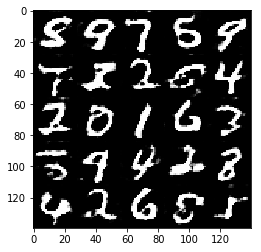

Epoch 2/2... Step 210/600... Discriminator Loss: 1.0715... Generator Loss: 1.6309
Epoch 2/2... Step 220/600... Discriminator Loss: 1.2674... Generator Loss: 0.6243
Epoch 2/2... Step 230/600... Discriminator Loss: 1.3266... Generator Loss: 0.5353
Epoch 2/2... Step 240/600... Discriminator Loss: 1.5687... Generator Loss: 0.3969
Epoch 2/2... Step 250/600... Discriminator Loss: 1.2347... Generator Loss: 0.7212
Epoch 2/2... Step 260/600... Discriminator Loss: 1.2488... Generator Loss: 0.6790
Epoch 2/2... Step 270/600... Discriminator Loss: 1.0865... Generator Loss: 1.1211
Epoch 2/2... Step 280/600... Discriminator Loss: 1.0502... Generator Loss: 0.9635
Epoch 2/2... Step 290/600... Discriminator Loss: 1.4428... Generator Loss: 2.0523
Epoch 2/2... Step 300/600... Discriminator Loss: 1.3593... Generator Loss: 0.5160


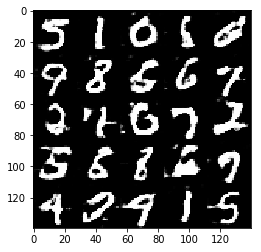

Epoch 2/2... Step 310/600... Discriminator Loss: 1.1033... Generator Loss: 0.9117
Epoch 2/2... Step 320/600... Discriminator Loss: 1.1146... Generator Loss: 1.2079
Epoch 2/2... Step 330/600... Discriminator Loss: 1.1563... Generator Loss: 0.8314
Epoch 2/2... Step 340/600... Discriminator Loss: 1.2980... Generator Loss: 0.6111
Epoch 2/2... Step 350/600... Discriminator Loss: 1.3465... Generator Loss: 0.5959
Epoch 2/2... Step 360/600... Discriminator Loss: 1.0842... Generator Loss: 1.2772
Epoch 2/2... Step 370/600... Discriminator Loss: 0.9811... Generator Loss: 1.4896
Epoch 2/2... Step 380/600... Discriminator Loss: 1.0445... Generator Loss: 1.2316
Epoch 2/2... Step 390/600... Discriminator Loss: 1.2028... Generator Loss: 0.7194
Epoch 2/2... Step 400/600... Discriminator Loss: 1.2765... Generator Loss: 0.5870


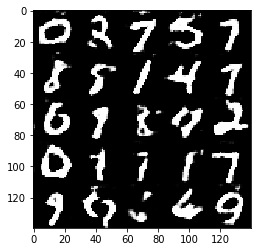

Epoch 2/2... Step 410/600... Discriminator Loss: 1.3889... Generator Loss: 0.5389
Epoch 2/2... Step 420/600... Discriminator Loss: 1.4845... Generator Loss: 0.4835
Epoch 2/2... Step 430/600... Discriminator Loss: 1.5272... Generator Loss: 0.4701
Epoch 2/2... Step 440/600... Discriminator Loss: 1.0185... Generator Loss: 1.5420
Epoch 2/2... Step 450/600... Discriminator Loss: 0.9812... Generator Loss: 1.1525
Epoch 2/2... Step 460/600... Discriminator Loss: 1.1285... Generator Loss: 0.8687
Epoch 2/2... Step 470/600... Discriminator Loss: 1.1146... Generator Loss: 0.7553
Epoch 2/2... Step 480/600... Discriminator Loss: 1.2220... Generator Loss: 0.6759
Epoch 2/2... Step 490/600... Discriminator Loss: 1.1685... Generator Loss: 0.8610
Epoch 2/2... Step 500/600... Discriminator Loss: 1.0062... Generator Loss: 0.9509


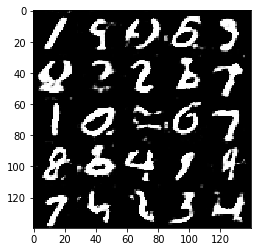

Epoch 2/2... Step 510/600... Discriminator Loss: 1.2244... Generator Loss: 0.6752
Epoch 2/2... Step 520/600... Discriminator Loss: 1.1687... Generator Loss: 1.1433
Epoch 2/2... Step 530/600... Discriminator Loss: 1.0873... Generator Loss: 0.9046
Epoch 2/2... Step 540/600... Discriminator Loss: 0.9866... Generator Loss: 1.1723
Epoch 2/2... Step 550/600... Discriminator Loss: 1.6313... Generator Loss: 2.3092
Epoch 2/2... Step 560/600... Discriminator Loss: 1.0532... Generator Loss: 0.9940
Epoch 2/2... Step 570/600... Discriminator Loss: 1.1344... Generator Loss: 0.7522
Epoch 2/2... Step 580/600... Discriminator Loss: 1.2120... Generator Loss: 0.6775
Epoch 2/2... Step 590/600... Discriminator Loss: 1.0869... Generator Loss: 2.1500
Epoch 2/2... Step 600/600... Discriminator Loss: 1.1223... Generator Loss: 0.8641


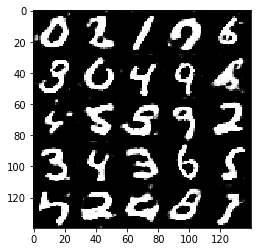

In [19]:
batch_size = 100
z_dim = 64
learning_rate = 0.00175
beta1 = 0.425 
alpha = 0.05

#batch_size = 100
#z_dim = 100
#learning_rate = 0.00175
#beta1 = 0.45
#alpha = 0.05

losses = []

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, alpha)

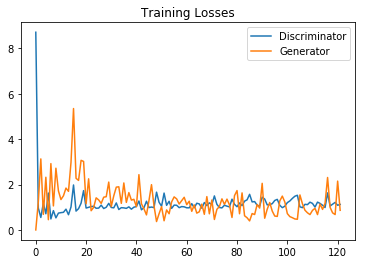

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Step 1/2026... Discriminator Loss: 9.4922... Generator Loss: 0.0004


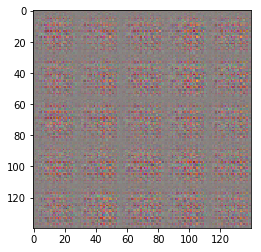

Epoch 1/1... Step 10/2026... Discriminator Loss: 1.5966... Generator Loss: 5.7733
Epoch 1/1... Step 20/2026... Discriminator Loss: 0.9734... Generator Loss: 1.1219
Epoch 1/1... Step 30/2026... Discriminator Loss: 1.3203... Generator Loss: 0.8643
Epoch 1/1... Step 40/2026... Discriminator Loss: 0.8709... Generator Loss: 1.4939
Epoch 1/1... Step 50/2026... Discriminator Loss: 1.1214... Generator Loss: 0.8132
Epoch 1/1... Step 60/2026... Discriminator Loss: 1.1069... Generator Loss: 2.4754
Epoch 1/1... Step 70/2026... Discriminator Loss: 0.9805... Generator Loss: 1.3494
Epoch 1/1... Step 80/2026... Discriminator Loss: 1.9530... Generator Loss: 3.2818
Epoch 1/1... Step 90/2026... Discriminator Loss: 0.9743... Generator Loss: 1.2162
Epoch 1/1... Step 100/2026... Discriminator Loss: 1.2141... Generator Loss: 1.5851


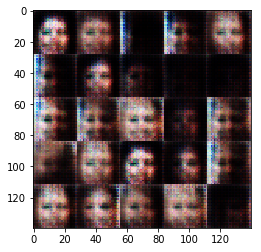

Epoch 1/1... Step 110/2026... Discriminator Loss: 1.4415... Generator Loss: 1.8744
Epoch 1/1... Step 120/2026... Discriminator Loss: 1.2156... Generator Loss: 0.7467
Epoch 1/1... Step 130/2026... Discriminator Loss: 1.3314... Generator Loss: 0.6974
Epoch 1/1... Step 140/2026... Discriminator Loss: 1.0363... Generator Loss: 1.4279
Epoch 1/1... Step 150/2026... Discriminator Loss: 1.0485... Generator Loss: 1.2120
Epoch 1/1... Step 160/2026... Discriminator Loss: 1.3093... Generator Loss: 0.7943
Epoch 1/1... Step 170/2026... Discriminator Loss: 1.2730... Generator Loss: 1.4422
Epoch 1/1... Step 180/2026... Discriminator Loss: 1.2113... Generator Loss: 0.7269
Epoch 1/1... Step 190/2026... Discriminator Loss: 1.2239... Generator Loss: 0.7291
Epoch 1/1... Step 200/2026... Discriminator Loss: 1.1467... Generator Loss: 0.9441


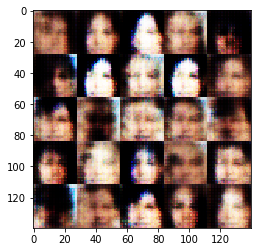

Epoch 1/1... Step 210/2026... Discriminator Loss: 1.3802... Generator Loss: 0.5844
Epoch 1/1... Step 220/2026... Discriminator Loss: 1.0068... Generator Loss: 0.9760
Epoch 1/1... Step 230/2026... Discriminator Loss: 0.8399... Generator Loss: 1.5567
Epoch 1/1... Step 240/2026... Discriminator Loss: 1.4478... Generator Loss: 0.5586
Epoch 1/1... Step 250/2026... Discriminator Loss: 1.0189... Generator Loss: 1.0448
Epoch 1/1... Step 260/2026... Discriminator Loss: 0.9587... Generator Loss: 1.1330
Epoch 1/1... Step 270/2026... Discriminator Loss: 1.1586... Generator Loss: 0.7292
Epoch 1/1... Step 280/2026... Discriminator Loss: 1.0159... Generator Loss: 1.0902
Epoch 1/1... Step 290/2026... Discriminator Loss: 1.0740... Generator Loss: 0.8207
Epoch 1/1... Step 300/2026... Discriminator Loss: 1.4006... Generator Loss: 0.7136


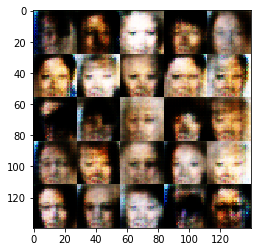

Epoch 1/1... Step 310/2026... Discriminator Loss: 0.9406... Generator Loss: 1.1453
Epoch 1/1... Step 320/2026... Discriminator Loss: 0.9027... Generator Loss: 1.3373
Epoch 1/1... Step 330/2026... Discriminator Loss: 1.0800... Generator Loss: 2.1218
Epoch 1/1... Step 340/2026... Discriminator Loss: 0.9515... Generator Loss: 0.9764
Epoch 1/1... Step 350/2026... Discriminator Loss: 1.4870... Generator Loss: 2.4514
Epoch 1/1... Step 360/2026... Discriminator Loss: 1.1650... Generator Loss: 1.0361
Epoch 1/1... Step 370/2026... Discriminator Loss: 0.9301... Generator Loss: 1.3276
Epoch 1/1... Step 380/2026... Discriminator Loss: 1.4028... Generator Loss: 1.9524
Epoch 1/1... Step 390/2026... Discriminator Loss: 1.0622... Generator Loss: 1.1902
Epoch 1/1... Step 400/2026... Discriminator Loss: 1.7398... Generator Loss: 0.3803


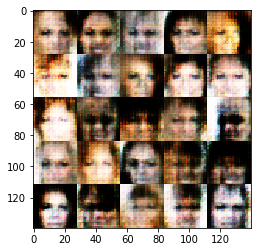

Epoch 1/1... Step 410/2026... Discriminator Loss: 1.0432... Generator Loss: 1.0700
Epoch 1/1... Step 420/2026... Discriminator Loss: 0.9779... Generator Loss: 1.4950
Epoch 1/1... Step 430/2026... Discriminator Loss: 0.9842... Generator Loss: 1.2632
Epoch 1/1... Step 440/2026... Discriminator Loss: 1.3058... Generator Loss: 0.6244
Epoch 1/1... Step 450/2026... Discriminator Loss: 1.1203... Generator Loss: 1.0408
Epoch 1/1... Step 460/2026... Discriminator Loss: 1.1238... Generator Loss: 1.8142
Epoch 1/1... Step 470/2026... Discriminator Loss: 1.2670... Generator Loss: 0.7219
Epoch 1/1... Step 480/2026... Discriminator Loss: 1.2833... Generator Loss: 3.2839
Epoch 1/1... Step 490/2026... Discriminator Loss: 1.1570... Generator Loss: 0.8134
Epoch 1/1... Step 500/2026... Discriminator Loss: 1.1497... Generator Loss: 0.9626


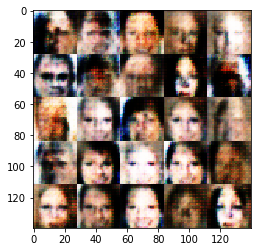

Epoch 1/1... Step 510/2026... Discriminator Loss: 1.1828... Generator Loss: 0.7825
Epoch 1/1... Step 520/2026... Discriminator Loss: 1.1661... Generator Loss: 2.0988
Epoch 1/1... Step 530/2026... Discriminator Loss: 1.2563... Generator Loss: 0.7334
Epoch 1/1... Step 540/2026... Discriminator Loss: 1.0771... Generator Loss: 0.8983
Epoch 1/1... Step 550/2026... Discriminator Loss: 1.7820... Generator Loss: 0.3884
Epoch 1/1... Step 560/2026... Discriminator Loss: 1.2015... Generator Loss: 0.7571
Epoch 1/1... Step 570/2026... Discriminator Loss: 1.2285... Generator Loss: 0.6691
Epoch 1/1... Step 580/2026... Discriminator Loss: 0.9849... Generator Loss: 1.0317
Epoch 1/1... Step 590/2026... Discriminator Loss: 1.1082... Generator Loss: 0.7656
Epoch 1/1... Step 600/2026... Discriminator Loss: 1.2366... Generator Loss: 2.0459


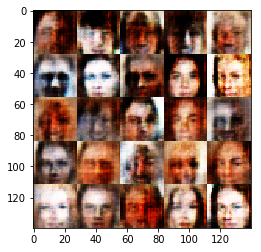

Epoch 1/1... Step 610/2026... Discriminator Loss: 2.3806... Generator Loss: 0.1823
Epoch 1/1... Step 620/2026... Discriminator Loss: 1.0965... Generator Loss: 0.9769
Epoch 1/1... Step 630/2026... Discriminator Loss: 1.0615... Generator Loss: 0.9983
Epoch 1/1... Step 640/2026... Discriminator Loss: 1.0080... Generator Loss: 1.1801
Epoch 1/1... Step 650/2026... Discriminator Loss: 0.9945... Generator Loss: 1.4288
Epoch 1/1... Step 660/2026... Discriminator Loss: 0.8843... Generator Loss: 1.3512
Epoch 1/1... Step 670/2026... Discriminator Loss: 1.0596... Generator Loss: 0.7807
Epoch 1/1... Step 680/2026... Discriminator Loss: 0.9844... Generator Loss: 1.0596
Epoch 1/1... Step 690/2026... Discriminator Loss: 0.9259... Generator Loss: 1.2970
Epoch 1/1... Step 700/2026... Discriminator Loss: 1.0028... Generator Loss: 1.1283


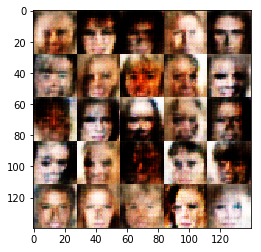

Epoch 1/1... Step 710/2026... Discriminator Loss: 0.9278... Generator Loss: 1.5044
Epoch 1/1... Step 720/2026... Discriminator Loss: 0.9754... Generator Loss: 1.4696
Epoch 1/1... Step 730/2026... Discriminator Loss: 1.0218... Generator Loss: 0.9824
Epoch 1/1... Step 740/2026... Discriminator Loss: 0.9790... Generator Loss: 1.1948
Epoch 1/1... Step 750/2026... Discriminator Loss: 1.0865... Generator Loss: 1.3320
Epoch 1/1... Step 760/2026... Discriminator Loss: 1.0718... Generator Loss: 1.4104
Epoch 1/1... Step 770/2026... Discriminator Loss: 1.2863... Generator Loss: 0.6330
Epoch 1/1... Step 780/2026... Discriminator Loss: 1.0386... Generator Loss: 1.6117
Epoch 1/1... Step 790/2026... Discriminator Loss: 0.8656... Generator Loss: 1.2655
Epoch 1/1... Step 800/2026... Discriminator Loss: 0.9356... Generator Loss: 1.1206


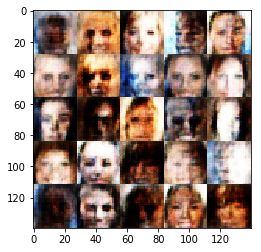

Epoch 1/1... Step 810/2026... Discriminator Loss: 1.0610... Generator Loss: 0.8518
Epoch 1/1... Step 820/2026... Discriminator Loss: 0.9081... Generator Loss: 1.4586
Epoch 1/1... Step 830/2026... Discriminator Loss: 0.8866... Generator Loss: 1.4663
Epoch 1/1... Step 840/2026... Discriminator Loss: 0.9581... Generator Loss: 1.4022
Epoch 1/1... Step 850/2026... Discriminator Loss: 1.3424... Generator Loss: 0.5654
Epoch 1/1... Step 860/2026... Discriminator Loss: 0.9881... Generator Loss: 1.9443
Epoch 1/1... Step 870/2026... Discriminator Loss: 1.0478... Generator Loss: 1.0120
Epoch 1/1... Step 880/2026... Discriminator Loss: 1.1669... Generator Loss: 0.7259
Epoch 1/1... Step 890/2026... Discriminator Loss: 0.9525... Generator Loss: 1.0236
Epoch 1/1... Step 900/2026... Discriminator Loss: 1.0971... Generator Loss: 0.9138


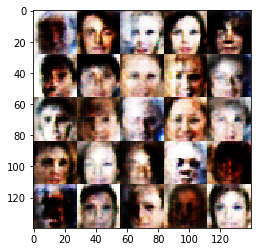

Epoch 1/1... Step 910/2026... Discriminator Loss: 0.9705... Generator Loss: 1.2237
Epoch 1/1... Step 920/2026... Discriminator Loss: 1.0156... Generator Loss: 0.9054
Epoch 1/1... Step 930/2026... Discriminator Loss: 1.4265... Generator Loss: 0.5197
Epoch 1/1... Step 940/2026... Discriminator Loss: 1.0634... Generator Loss: 0.8409
Epoch 1/1... Step 950/2026... Discriminator Loss: 0.9712... Generator Loss: 0.9540
Epoch 1/1... Step 960/2026... Discriminator Loss: 1.0888... Generator Loss: 0.9039
Epoch 1/1... Step 970/2026... Discriminator Loss: 1.1529... Generator Loss: 1.8778
Epoch 1/1... Step 980/2026... Discriminator Loss: 1.1588... Generator Loss: 0.6983
Epoch 1/1... Step 990/2026... Discriminator Loss: 1.0175... Generator Loss: 0.9725
Epoch 1/1... Step 1000/2026... Discriminator Loss: 0.9796... Generator Loss: 1.0441


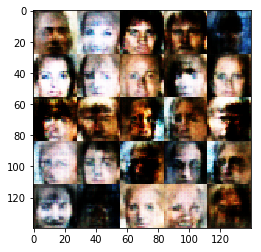

Epoch 1/1... Step 1010/2026... Discriminator Loss: 1.1170... Generator Loss: 0.8004
Epoch 1/1... Step 1020/2026... Discriminator Loss: 1.3083... Generator Loss: 0.5840
Epoch 1/1... Step 1030/2026... Discriminator Loss: 1.1219... Generator Loss: 0.7323
Epoch 1/1... Step 1040/2026... Discriminator Loss: 0.9846... Generator Loss: 1.0910
Epoch 1/1... Step 1050/2026... Discriminator Loss: 1.2304... Generator Loss: 2.3488
Epoch 1/1... Step 1060/2026... Discriminator Loss: 0.9413... Generator Loss: 1.3262
Epoch 1/1... Step 1070/2026... Discriminator Loss: 1.3050... Generator Loss: 0.5907
Epoch 1/1... Step 1080/2026... Discriminator Loss: 0.9972... Generator Loss: 1.3964
Epoch 1/1... Step 1090/2026... Discriminator Loss: 1.0330... Generator Loss: 1.4785
Epoch 1/1... Step 1100/2026... Discriminator Loss: 1.3334... Generator Loss: 2.8626


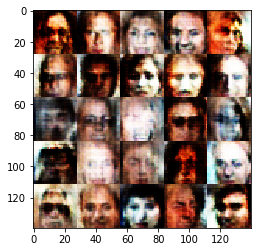

Epoch 1/1... Step 1110/2026... Discriminator Loss: 1.2372... Generator Loss: 0.6514
Epoch 1/1... Step 1120/2026... Discriminator Loss: 1.1442... Generator Loss: 1.8409
Epoch 1/1... Step 1130/2026... Discriminator Loss: 1.7999... Generator Loss: 0.3231
Epoch 1/1... Step 1140/2026... Discriminator Loss: 0.9609... Generator Loss: 1.1497
Epoch 1/1... Step 1150/2026... Discriminator Loss: 0.9452... Generator Loss: 1.4715
Epoch 1/1... Step 1160/2026... Discriminator Loss: 0.9974... Generator Loss: 1.2869
Epoch 1/1... Step 1170/2026... Discriminator Loss: 0.9201... Generator Loss: 1.5704
Epoch 1/1... Step 1180/2026... Discriminator Loss: 1.0729... Generator Loss: 1.7671
Epoch 1/1... Step 1190/2026... Discriminator Loss: 0.9961... Generator Loss: 1.0722
Epoch 1/1... Step 1200/2026... Discriminator Loss: 0.9678... Generator Loss: 1.0920


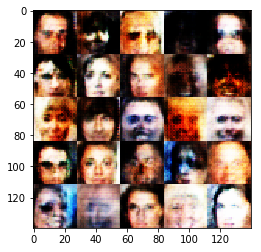

Epoch 1/1... Step 1210/2026... Discriminator Loss: 0.9958... Generator Loss: 1.1086
Epoch 1/1... Step 1220/2026... Discriminator Loss: 1.2044... Generator Loss: 0.6400
Epoch 1/1... Step 1230/2026... Discriminator Loss: 0.9533... Generator Loss: 1.2168
Epoch 1/1... Step 1240/2026... Discriminator Loss: 0.9825... Generator Loss: 1.0906
Epoch 1/1... Step 1250/2026... Discriminator Loss: 0.9447... Generator Loss: 1.2010
Epoch 1/1... Step 1260/2026... Discriminator Loss: 0.9171... Generator Loss: 1.3449
Epoch 1/1... Step 1270/2026... Discriminator Loss: 0.9435... Generator Loss: 1.7612
Epoch 1/1... Step 1280/2026... Discriminator Loss: 1.0722... Generator Loss: 1.0281
Epoch 1/1... Step 1290/2026... Discriminator Loss: 1.3088... Generator Loss: 0.6010
Epoch 1/1... Step 1300/2026... Discriminator Loss: 1.0442... Generator Loss: 0.9423


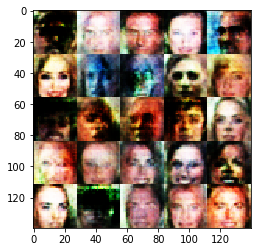

Epoch 1/1... Step 1310/2026... Discriminator Loss: 0.9459... Generator Loss: 1.0073
Epoch 1/1... Step 1320/2026... Discriminator Loss: 1.1555... Generator Loss: 0.7057
Epoch 1/1... Step 1330/2026... Discriminator Loss: 1.3545... Generator Loss: 0.5507
Epoch 1/1... Step 1340/2026... Discriminator Loss: 1.2085... Generator Loss: 0.6774
Epoch 1/1... Step 1350/2026... Discriminator Loss: 1.0559... Generator Loss: 2.0276
Epoch 1/1... Step 1360/2026... Discriminator Loss: 1.0238... Generator Loss: 1.0069
Epoch 1/1... Step 1370/2026... Discriminator Loss: 0.9914... Generator Loss: 1.5898
Epoch 1/1... Step 1380/2026... Discriminator Loss: 1.1318... Generator Loss: 2.0731
Epoch 1/1... Step 1390/2026... Discriminator Loss: 0.9140... Generator Loss: 2.1267
Epoch 1/1... Step 1400/2026... Discriminator Loss: 0.9798... Generator Loss: 1.0294


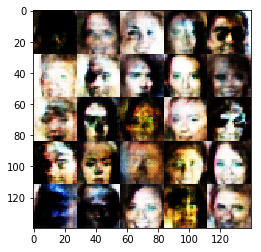

Epoch 1/1... Step 1410/2026... Discriminator Loss: 0.8745... Generator Loss: 1.5554
Epoch 1/1... Step 1420/2026... Discriminator Loss: 1.3476... Generator Loss: 0.5552
Epoch 1/1... Step 1430/2026... Discriminator Loss: 1.3702... Generator Loss: 0.5623
Epoch 1/1... Step 1440/2026... Discriminator Loss: 1.0625... Generator Loss: 1.3537
Epoch 1/1... Step 1450/2026... Discriminator Loss: 0.9805... Generator Loss: 1.6148
Epoch 1/1... Step 1460/2026... Discriminator Loss: 1.0102... Generator Loss: 1.4575
Epoch 1/1... Step 1470/2026... Discriminator Loss: 0.9312... Generator Loss: 1.0995
Epoch 1/1... Step 1480/2026... Discriminator Loss: 1.0149... Generator Loss: 1.6012
Epoch 1/1... Step 1490/2026... Discriminator Loss: 0.9804... Generator Loss: 1.1235
Epoch 1/1... Step 1500/2026... Discriminator Loss: 1.0058... Generator Loss: 1.2225


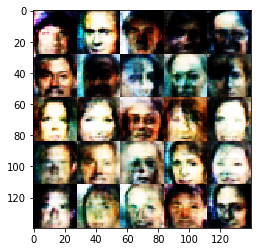

Epoch 1/1... Step 1510/2026... Discriminator Loss: 0.9855... Generator Loss: 1.0569
Epoch 1/1... Step 1520/2026... Discriminator Loss: 0.9696... Generator Loss: 1.0319
Epoch 1/1... Step 1530/2026... Discriminator Loss: 1.3273... Generator Loss: 0.5739
Epoch 1/1... Step 1540/2026... Discriminator Loss: 1.0729... Generator Loss: 1.4398
Epoch 1/1... Step 1550/2026... Discriminator Loss: 1.3050... Generator Loss: 0.6057
Epoch 1/1... Step 1560/2026... Discriminator Loss: 0.9719... Generator Loss: 1.4893
Epoch 1/1... Step 1570/2026... Discriminator Loss: 1.3109... Generator Loss: 0.5636
Epoch 1/1... Step 1580/2026... Discriminator Loss: 1.1027... Generator Loss: 0.8000
Epoch 1/1... Step 1590/2026... Discriminator Loss: 1.4601... Generator Loss: 2.9351
Epoch 1/1... Step 1600/2026... Discriminator Loss: 1.0512... Generator Loss: 1.2967


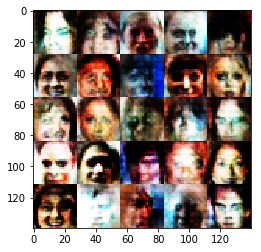

Epoch 1/1... Step 1610/2026... Discriminator Loss: 0.9895... Generator Loss: 1.3817
Epoch 1/1... Step 1620/2026... Discriminator Loss: 1.0126... Generator Loss: 0.9879
Epoch 1/1... Step 1630/2026... Discriminator Loss: 1.0399... Generator Loss: 1.2882
Epoch 1/1... Step 1640/2026... Discriminator Loss: 1.0492... Generator Loss: 2.0486
Epoch 1/1... Step 1650/2026... Discriminator Loss: 1.3844... Generator Loss: 0.5717
Epoch 1/1... Step 1660/2026... Discriminator Loss: 1.1588... Generator Loss: 0.7966
Epoch 1/1... Step 1670/2026... Discriminator Loss: 0.9299... Generator Loss: 1.1474
Epoch 1/1... Step 1680/2026... Discriminator Loss: 1.1936... Generator Loss: 2.0912
Epoch 1/1... Step 1690/2026... Discriminator Loss: 1.0285... Generator Loss: 1.9114
Epoch 1/1... Step 1700/2026... Discriminator Loss: 1.2526... Generator Loss: 1.5503


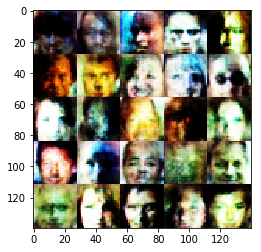

Epoch 1/1... Step 1710/2026... Discriminator Loss: 1.0408... Generator Loss: 1.3228
Epoch 1/1... Step 1720/2026... Discriminator Loss: 0.9683... Generator Loss: 1.0913
Epoch 1/1... Step 1730/2026... Discriminator Loss: 1.2741... Generator Loss: 0.6757
Epoch 1/1... Step 1740/2026... Discriminator Loss: 1.0179... Generator Loss: 1.1423
Epoch 1/1... Step 1750/2026... Discriminator Loss: 1.0901... Generator Loss: 0.8639
Epoch 1/1... Step 1760/2026... Discriminator Loss: 1.2982... Generator Loss: 2.0700
Epoch 1/1... Step 1770/2026... Discriminator Loss: 1.0416... Generator Loss: 0.9270
Epoch 1/1... Step 1780/2026... Discriminator Loss: 1.1727... Generator Loss: 0.7311
Epoch 1/1... Step 1790/2026... Discriminator Loss: 1.1727... Generator Loss: 0.7356
Epoch 1/1... Step 1800/2026... Discriminator Loss: 1.2453... Generator Loss: 0.6227


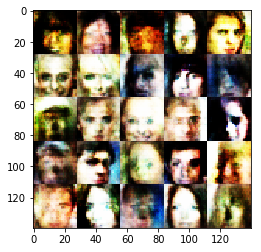

Epoch 1/1... Step 1810/2026... Discriminator Loss: 1.0364... Generator Loss: 0.9135
Epoch 1/1... Step 1820/2026... Discriminator Loss: 1.0771... Generator Loss: 0.9188
Epoch 1/1... Step 1830/2026... Discriminator Loss: 0.9478... Generator Loss: 0.9844
Epoch 1/1... Step 1840/2026... Discriminator Loss: 1.1237... Generator Loss: 0.7740
Epoch 1/1... Step 1850/2026... Discriminator Loss: 1.0829... Generator Loss: 1.6101
Epoch 1/1... Step 1860/2026... Discriminator Loss: 1.2478... Generator Loss: 1.7018
Epoch 1/1... Step 1870/2026... Discriminator Loss: 1.1417... Generator Loss: 0.7580
Epoch 1/1... Step 1880/2026... Discriminator Loss: 0.8919... Generator Loss: 1.2690
Epoch 1/1... Step 1890/2026... Discriminator Loss: 1.4692... Generator Loss: 0.4913
Epoch 1/1... Step 1900/2026... Discriminator Loss: 1.0511... Generator Loss: 1.1003


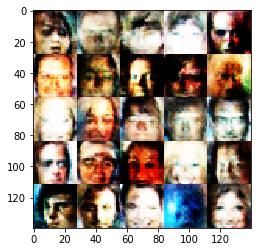

Epoch 1/1... Step 1910/2026... Discriminator Loss: 1.3355... Generator Loss: 0.6196
Epoch 1/1... Step 1920/2026... Discriminator Loss: 1.1388... Generator Loss: 0.8504
Epoch 1/1... Step 1930/2026... Discriminator Loss: 1.3708... Generator Loss: 0.5411
Epoch 1/1... Step 1940/2026... Discriminator Loss: 1.0312... Generator Loss: 1.2822
Epoch 1/1... Step 1950/2026... Discriminator Loss: 0.9347... Generator Loss: 1.2530
Epoch 1/1... Step 1960/2026... Discriminator Loss: 1.0381... Generator Loss: 1.3558
Epoch 1/1... Step 1970/2026... Discriminator Loss: 1.2114... Generator Loss: 1.6360
Epoch 1/1... Step 1980/2026... Discriminator Loss: 1.1049... Generator Loss: 0.9868
Epoch 1/1... Step 1990/2026... Discriminator Loss: 1.1387... Generator Loss: 0.7637
Epoch 1/1... Step 2000/2026... Discriminator Loss: 1.2651... Generator Loss: 0.6614


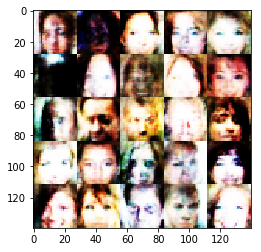

Epoch 1/1... Step 2010/2026... Discriminator Loss: 1.0664... Generator Loss: 0.8914
Epoch 1/1... Step 2020/2026... Discriminator Loss: 1.1510... Generator Loss: 1.8074


In [22]:
batch_size = 100
z_dim = 64
learning_rate = 0.00175
beta1 = 0.425 
alpha = 0.05

losses = []

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode,alpha)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.